# Building a Topic Classifier using Azure OpenAI GPT

### Problem description
    Build topic classifier to route route user questions into different topics.

    On workflow, this topic classifier comes before several ChatGPT chatbots that addressing questions on their own topics.
### Background
    The chatbot is for an insurance company called Contoso, Ltd. The insurance company provide two services: auto and home flood insurance.
    
    The six topics are:
        1 'auto insurance premium'
        2 'home flood insurance'
        3 'irrelevant of insurance'
        4 'chit chat'
        5 'end conversation'
        6 'continued conversation'
### Data
    Data is manually generated by multiple GPT API calls, it's purely synthetic. 
    There are 66 rows in total, and it covers the 6 topics mentioned above. Each row contains one round of QnA between customer and agent, with topic labeled.

### Approach
    Understanding data: exploratory data analysis (EDA), 
    Build models: build 4 models in total including zero/few-shot across two models: text-davinci-003 and text-curie-001 
            zero-shot
                text-davinci-003
                text-curie-001
            few-shot
                text-davinci-003
                text-curie-001
    Compare performancemetrics from 4 models and pick the best one.

### Result
    Topic classifier working as expected and evaluation metrics on 66 synthetic dataset reported.
    Overall, few-shot text-curie-001 performs better than zero-shot text-curie-001, and text-davinci-003 outperforms text-curie-001. On text-davinci-003, both zero-shot and few-shot performs the same, achieving >98% on weighted accuracy/precision/recall.
    When applying to real business classification problems, please evaluate with production dataset and pick the best model based on performance and cost.



# set up

In [1]:
# please make sure to install libraries: pip install -r requirements.txt
import json
import jsonlines
import logging
logging.basicConfig(filename='ctc.log', encoding='utf-8', level=logging.DEBUG)
logger = logging.getLogger('ftpuploader')
import numpy as np
import matplotlib.pyplot as plt
import os
import openai
import pandas as pd
import re
import seaborn as sns
import sys
import time
import yaml

from datetime import date, datetime
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [2]:
openai.api_type = "azure"    
openai.api_key = os.getenv('AOAI_CHATGPT_API_KEY')
openai.api_base = "https://{your-resource-name}.openai.azure.com/"
openai.api_version = "2022-12-01"

# load data

In [3]:
# read the synthetic dataset
df_raw = pd.read_csv("synthetic_data_topic_classifier.csv")

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   QnA                66 non-null     object
 1   topic              66 non-null     object
 2   customer_question  66 non-null     object
 3   agent_reply        66 non-null     object
dtypes: object(4)
memory usage: 2.2+ KB


In [5]:
df_raw.sample()

,QnA,topic,customer_question,agent_reply
62,"Customer: Do you have any other information?\nAgent: Sure thing, I can tell you more.",continued conversation,Customer: Do you have any other information?,"Agent: Sure thing, I can tell you more."


# Data Cleaning and EDA

In [6]:
# print out all topics for easy reading and creating map
set_topics = set()

for grouped_types in df_raw.topic.unique():
    for ea_type in grouped_types.split(','):
        set_topics.add(ea_type.strip(" ''[]"))

set_topics

{'auto insurance premium',
 'chit chat',
 'continued conversation',
 'end conversation',
 'home flood insurance',
 'irrelevant of insurance'}

In [7]:
# create a map: mapping topic name strings to numbers
# numbers as categories for classification are easier to control and helps reduces halluciation
map_t_n = {'auto insurance premium': 1,
        'home flood insurance': 2,
        'irrelevant of insurance': 3,
        'chit chat': 4,
        'end conversation': 5,
        'continued conversation': 6}

In [8]:
df_raw['choice'] = df_raw.topic.apply(lambda x: map_t_n[x])

In [9]:
df_raw['completion'] = df_raw.choice.apply(lambda x: ' ' + str(x) + ' END')

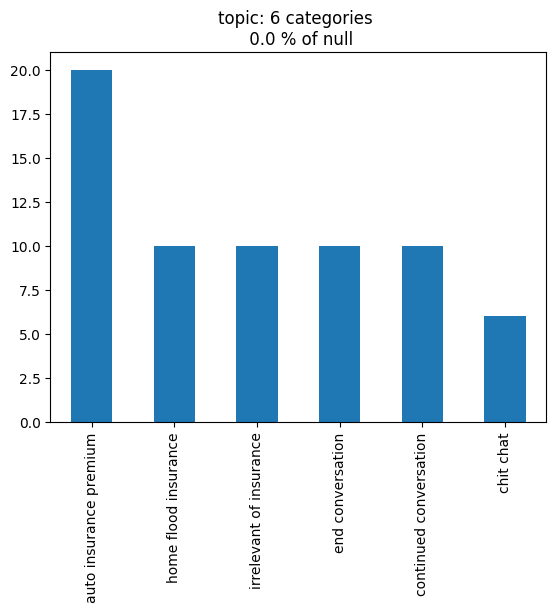

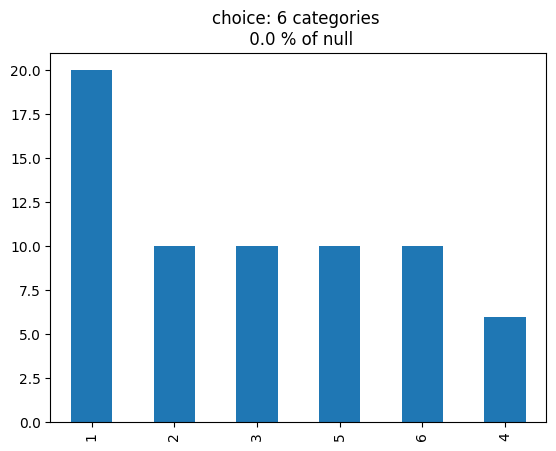

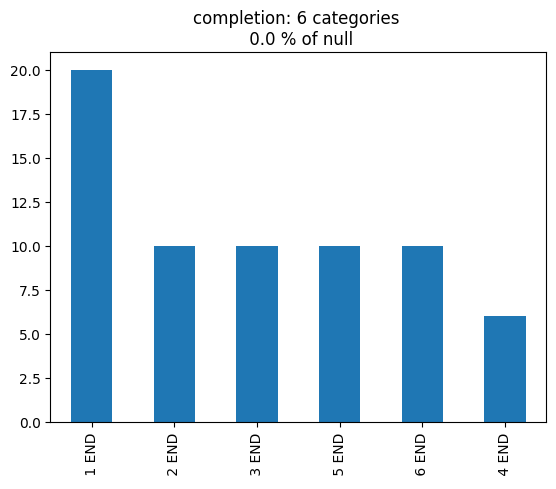

In [10]:
for col in df_raw.columns:
    if col in ['QnA', 'customer_question', 'agent_reply'] or df_raw[col].isnull().all():
        continue
    plt.figure()
    df_raw[col].value_counts().plot.bar()
    pct_null = np.round(df_raw[col].isnull().sum() / df_raw.shape[0] * 100, 1)
    plt.title(f'{col}: {df_raw[col].astype(str).transform(tuple).nunique()} categories \n {pct_null} % of null')

# pre-processing

In [11]:
def pre_processing(df, prompt_content, output_path, tag_few_shot=False):
    '''
    prompt assembly
    align format (with 'prompt' as column name, and then save ad json)
    save pre-processed data
    '''

    df_raw = df.copy()
    df_raw['prompt_original'] = df_raw.customer_question
    
    if tag_few_shot:
        df_raw['prompt'] = (prompt_content + 'Customer question: '+ df_raw.customer_question +'\nClassified topic: '
                           )
    else:
        df_raw['prompt'] = (f"Insurer's question:\n" + df_raw.customer_question
                    + '\n' + prompt_content)

    df_sample = df_raw.copy()
    df_sample.to_csv(f'{output_path}.csv')
    
    save_path = f'{output_path}.jsonl'
    df_sample.to_json(save_path, orient='records', lines=True)
    
    print(df_sample.info())
    print(f'data saved at {save_path}')
    print('----show a sample prompt for visual check----')
    print(df_sample.prompt.iloc[0])
    
    return df_sample, save_path

In [12]:
for pair in map_t_n.items():
    print(f"{pair[1]} '{pair[0]}'")


1 'auto insurance premium'
2 'home flood insurance'
3 'irrelevant of insurance'
4 'chit chat'
5 'end conversation'
6 'continued conversation'


# batch prediction


In [13]:
def stage_examples_for_prediction(input_json_address):
    '''Preparing the test data for inferencing'''
    example_list = []
    with jsonlines.open(input_json_address) as reader:
        for obj in reader:
            example_list.append(obj)
    return example_list

In [14]:
def batch_predict(MODEL_NAME, data_path, col_interest):
    '''
    inference, score test case
    **note** max tokens for multi-label classification completion use 3 for this case
    '''
    data = stage_examples_for_prediction(data_path)
    model_prompt = [x['prompt'] for x in data]
    COMPLETION_END = ' END'
    
    # divide into groups of 15 using VAL_CHUNK_SIZE because of restrctions imposed by OpenAI
    response_list = []
    prob_list = []
    VAL_CHUNK_SIZE = 15
    MAX_TOKENS = 3

    n_rounds = int(np.ceil(len(model_prompt)/VAL_CHUNK_SIZE))
    print('total number of rounds:', n_rounds)
    print('current run')
    
    for i in range(n_rounds):
        # time.sleep(1) #need to increase to a larger value to run the larger set
        
        i_start = i * VAL_CHUNK_SIZE
        if i == n_rounds - 1:
            i_end = len(model_prompt) + 1
        else:
            i_end = (i + 1) * VAL_CHUNK_SIZE
        
        if i % int(n_rounds/20 + 1) == 0:
            print(i)
                
        try:
            model_prompt_i = model_prompt[i_start: i_end]
            if len(model_prompt_i) == 0:
                break

            # call model for responses
            response = openai.Completion.create(
                        engine=MODEL_NAME,
                        prompt = model_prompt_i,
                        temperature = 0,
                        max_tokens = MAX_TOKENS,
                        frequency_penalty = 0.0,
                        presence_penalty = 0.0,
                        stop = [COMPLETION_END],
                        best_of = 1,
                        logprobs= 3,
                      )

            #extract response list
            for choices in response['choices']:
                response_list += [choices['text']]

                d = choices['logprobs']['top_logprobs'][0]
                k = max(d, key=d.get)
                if k == ' 1':
                    prob = np.exp(d[k])
                else:
                    prob = 1 - np.exp(d[k])

                prob_list += [prob]
        except BaseException as e:
            logger.exception('failure while calling Azure OpenAI API')
            for i in range(i_start, i_end):
                response_list.append(f'error in batch: {str(e)}')
                prob_list.append(0)
            pass
            
            
    y_pred = response_list  
  
    df_evaluate = pd.DataFrame()
    df_evaluate['prompt'] = model_prompt
    df_evaluate['pred'] = y_pred
    df_evaluate['probs_pred'] = prob_list
    df_evaluate[col_interest] = [x[col_interest] for x in data]
    
    return df_evaluate

In [15]:
def post_processing(df_evaluate_reasons_raw):
    '''
    clean output
    visualize output
    '''
    
    # failure could be due to content filter
    n_failed = df_evaluate_reasons_raw[df_evaluate_reasons_raw.pred.isin(['error in batch: Error communicating with OpenAI', None])].shape[0]
    print(f'failed number of cases {n_failed}')

    df_evaluate_reasons = df_evaluate_reasons_raw[~df_evaluate_reasons_raw.pred.isin(['error in batch: Error communicating with OpenAI', None])]
    df_evaluate_reasons['ground_truth'] = df_evaluate_reasons.completion.str.strip(' ,END')
    df_evaluate_reasons['pred'] = df_evaluate_reasons['pred'].astype('str').str.strip(' \n.')
    df_evaluate_reasons['pred_class'] = df_evaluate_reasons.pred.copy()
    df_evaluate_reasons.to_csv('evaluate_incident_type_plain_choice.csv')

    display(df_evaluate_reasons.pred_class.value_counts().sort_index())
    display(df_evaluate_reasons.ground_truth.value_counts().sort_index())


    plt.figure()
    df_evaluate_reasons.pred_class.value_counts().sort_index().plot.bar()
    plt.title(f'predicted, number of classes {df_evaluate_reasons.pred_class.transform(tuple).nunique()}')

    plt.figure()
    df_evaluate_reasons.ground_truth.value_counts().sort_index().plot.bar()
    plt.title(f'ground_truth, number of classes {df_evaluate_reasons.pred_class.transform(tuple).nunique()}')
    
    return df_evaluate_reasons

# metric

### confusion matrix

In [16]:
def eval_classification(df, col_GT, col_pred):
    '''
    display classificatione evaluation metrics and confusion matrix
    '''
    df = df.copy()
    y_true = df[col_GT].astype(str)
    y_pred = df[col_pred].astype(str)
    labels = sorted(set(y_true.unique()).union(set(y_pred.unique())))
    
    cf_matrix = confusion_matrix(y_true, y_pred)
    # display(cf_matrix)
    
    fig, ax = plt.subplots(1, figsize=(10,10))
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, 
                                        display_labels=labels
                                       )
    
    cm_display.plot(ax=ax, xticks_rotation='vertical')
    print(classification_report(y_true, y_pred, zero_division=1))
    
    return None

# result display

In [17]:
def chained_process_eval(classifier_model, classifier_path):
    '''
    combine function on prediction, post-processing, and evaluation
    '''
    df_evaluate_reasons_raw = batch_predict(classifier_model, classifier_path, 'completion')
    try:
        df_evaluate_reasons = post_processing(df_evaluate_reasons_raw)
        eval_classification(df_evaluate_reasons, 'ground_truth', 'pred_class')
    except:
        display('error')
        df_evaluate_reasons = df_evaluate_reasons_raw.copy()
        
    display(df_evaluate_reasons.pred.value_counts())
    
    return df_evaluate_reasons

# compare results

    zero-shot
        text-davinci-003
        text-curie-001

    few-shot
        text-davinci-003
        text-curie-001
    

# zero-shot prompt engineering and results

In [18]:
prompt_zero_shot = '''

Based on the customer question above, choose one choice below that best describe the question content. Classify between category 1 to 6.
Make choices based on provided facts, don't imply nor make up stuff.

Detailed Guidelines for how to choose:
    choose 1 if the question is about auto insurance premium.
    choose 2 if the question is about home flood insurance.
    choose 3 if the question is irrelevant of insurance.
    choose 4 if the question is chit chat.
    choose 5 if the question is about ending conversation.
    choose 6 if the question is just a continuation of previous question.
Choose one correct number: 
'''

In [19]:
df, file_path_zero_shot = pre_processing(df_raw, prompt_zero_shot, output_path='prompt_zero_shot')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   QnA                66 non-null     object
 1   topic              66 non-null     object
 2   customer_question  66 non-null     object
 3   agent_reply        66 non-null     object
 4   choice             66 non-null     int64 
 5   completion         66 non-null     object
 6   prompt_original    66 non-null     object
 7   prompt             66 non-null     object
dtypes: int64(1), object(7)
memory usage: 4.2+ KB
None
data saved at prompt_zero_shot.jsonl
----show a sample prompt for visual check----
Insurer's question:
How are auto insurance premiums calculated?


Based on the customer question above, choose one choice below that best describe the question content. Classify between category 1 to 6.
Make choices based on provided facts, don't imply nor make up stuff.

Detailed Guidelin

text-davinci-003 prompt_zero_shot.jsonl
total number of rounds: 5
current run
0
1
2
3
4
failed number of cases 0


1    20
2    10
3    10
4     8
5     9
6     9
Name: pred_class, dtype: int64

1    20
2    10
3    10
4     6
5    10
6    10
Name: ground_truth, dtype: int64

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       0.75      1.00      0.86         6
           5       0.89      0.80      0.84        10
           6       1.00      0.90      0.95        10

    accuracy                           0.95        66
   macro avg       0.94      0.95      0.94        66
weighted avg       0.96      0.95      0.96        66



1    20
2    10
3    10
5     9
6     9
4     8
Name: pred, dtype: int64

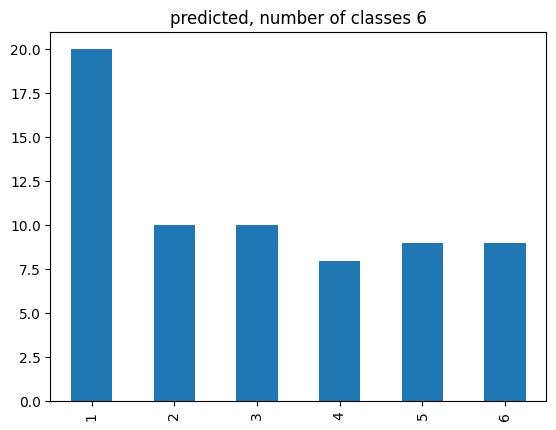

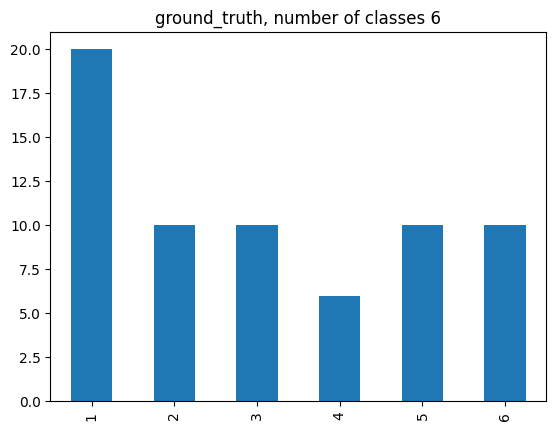

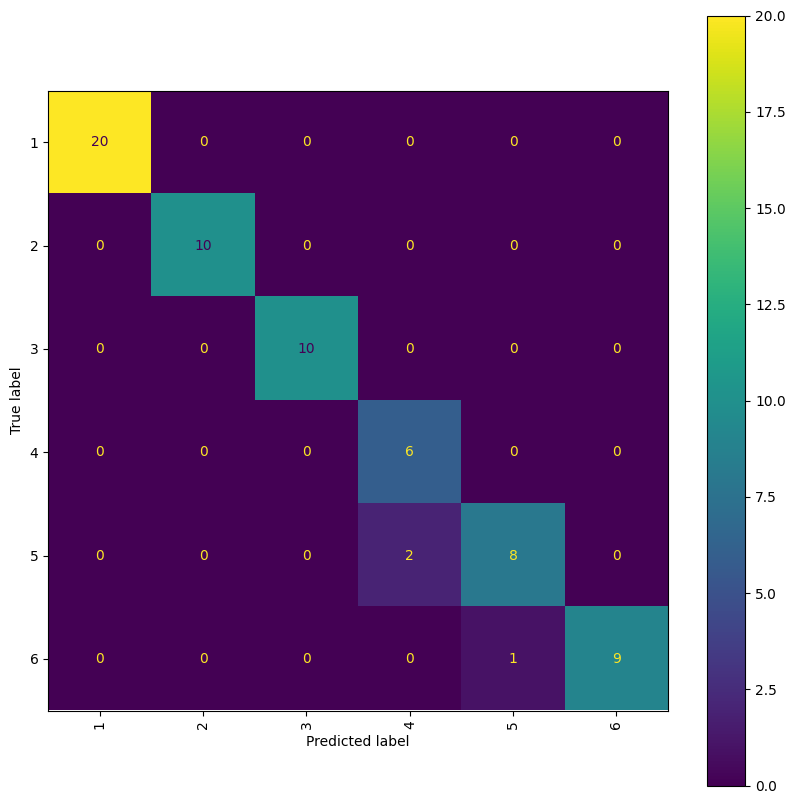

In [20]:
classifier_model = 'text-davinci-003'
classifier_path = file_path_zero_shot
print(classifier_model, classifier_path)
df_evaluate_reasons = chained_process_eval(classifier_model, classifier_path)

text-curie-001 prompt_zero_shot.jsonl
total number of rounds: 5
current run
0
1
2
3
4
failed number of cases 0


1    66
Name: pred_class, dtype: int64

1    20
2    10
3    10
4     6
5    10
6    10
Name: ground_truth, dtype: int64

              precision    recall  f1-score   support

           1       0.30      1.00      0.47        20
           2       1.00      0.00      0.00        10
           3       1.00      0.00      0.00        10
           4       1.00      0.00      0.00         6
           5       1.00      0.00      0.00        10
           6       1.00      0.00      0.00        10

    accuracy                           0.30        66
   macro avg       0.88      0.17      0.08        66
weighted avg       0.79      0.30      0.14        66



1    66
Name: pred, dtype: int64

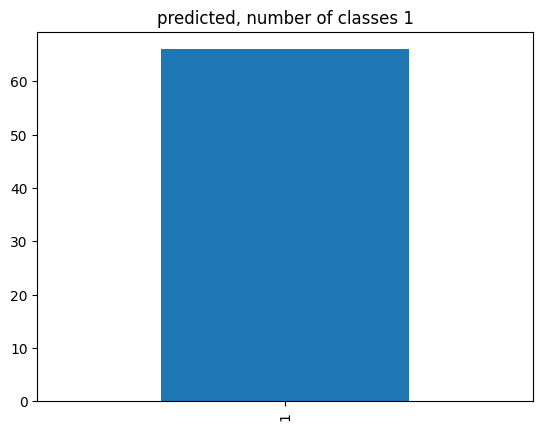

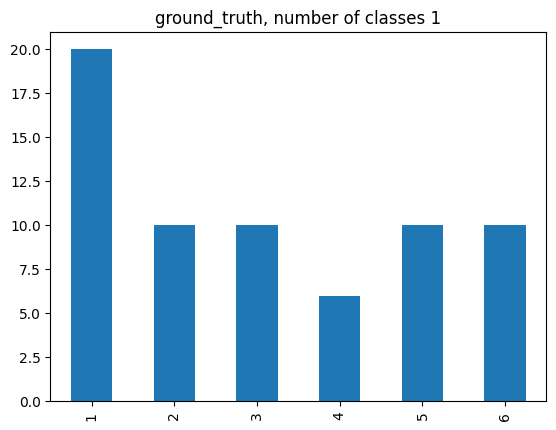

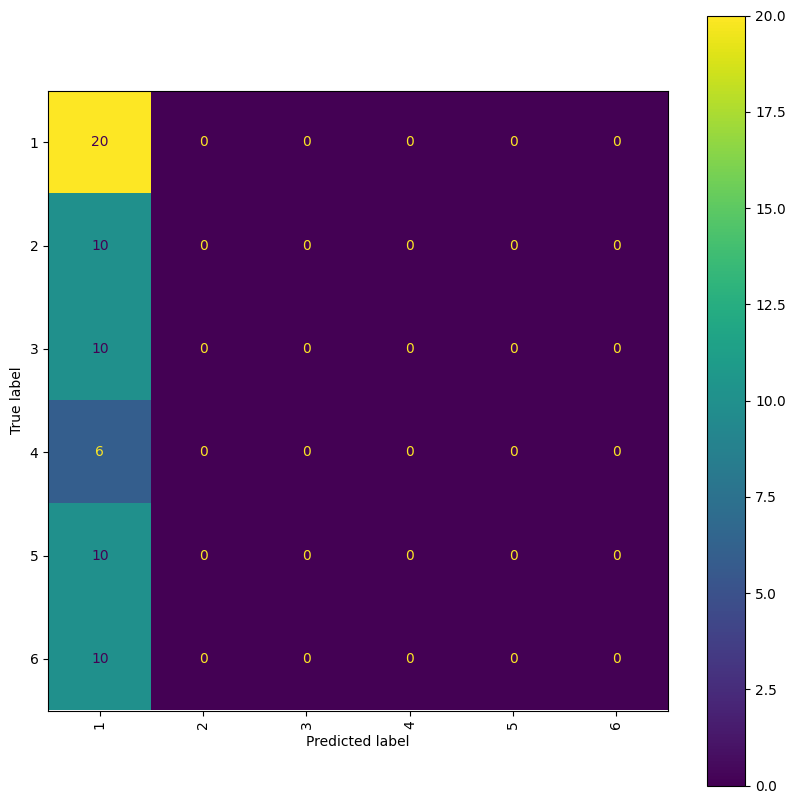

In [21]:
classifier_model = 'text-curie-001'
classifier_path = file_path_zero_shot
print(classifier_model, classifier_path)
df_evaluate_reasons = chained_process_eval(classifier_model, classifier_path)

# few-shot prompt engineering and results

In [22]:
prompt_few_shot = f'''
Classify customer's question. Classify between category 1 to 6.

Detailed guidelines for how to choose:
    choose 1 if the question is about auto insurance premium.
    choose 2 if the question is about home flood insurance.
    choose 3 if the question is irrelevant of insurance.
    choose 4 if the question is chit chat.
    choose 5 if the question is about ending conversation.
    choose 6 if the question is just a continuation of previous question.
    
Customer question: Hi there, do you know how to choose flood insurance?
Classified topic:2

Customer question: Hi there, I have a question on my auto insurance.
Classified topic:1

Customer question: Hi there, do you know how to apply for financial aid?
Classified topic:3

Customer question: How is your day?
Classified topic:4

Customer question: Thanks, I got all I need.
Classified topic:5

Customer question: Can you tell me more about it?
Classified topic:6


'''

df_few_shot, file_path_few_shot = pre_processing(df_raw, prompt_few_shot, output_path='prompt_few_shot', tag_few_shot=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   QnA                66 non-null     object
 1   topic              66 non-null     object
 2   customer_question  66 non-null     object
 3   agent_reply        66 non-null     object
 4   choice             66 non-null     int64 
 5   completion         66 non-null     object
 6   prompt_original    66 non-null     object
 7   prompt             66 non-null     object
dtypes: int64(1), object(7)
memory usage: 4.2+ KB
None
data saved at prompt_few_shot.jsonl
----show a sample prompt for visual check----

Classify customer's question. Classify between category 1 to 6.

Detailed guidelines for how to choose:
    choose 1 if the question is about auto insurance premium.
    choose 2 if the question is about home flood insurance.
    choose 3 if the question is irrelevant of insurance.
    cho

text-davinci-003 prompt_few_shot.jsonl
total number of rounds: 5
current run
0
1
2
3
4
failed number of cases 0


1    20
2    10
3    10
4     6
5    11
6     9
Name: pred_class, dtype: int64

1    20
2    10
3    10
4     6
5    10
6    10
Name: ground_truth, dtype: int64

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00         6
           5       0.91      1.00      0.95        10
           6       1.00      0.90      0.95        10

    accuracy                           0.98        66
   macro avg       0.98      0.98      0.98        66
weighted avg       0.99      0.98      0.98        66



1    20
5    11
2    10
3    10
6     9
4     6
Name: pred, dtype: int64

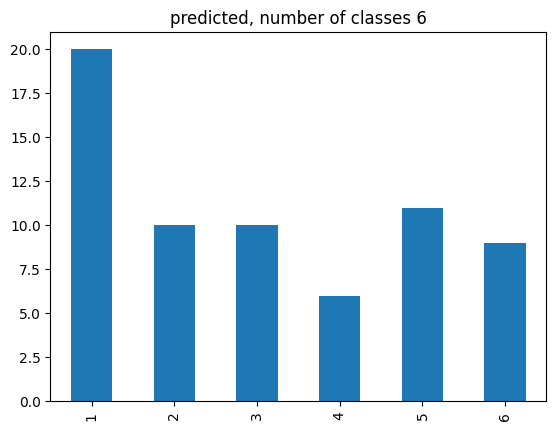

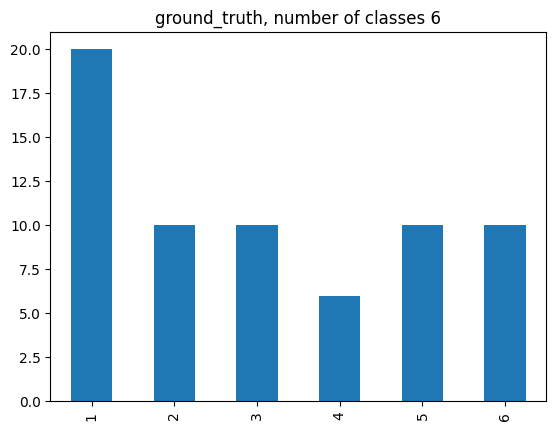

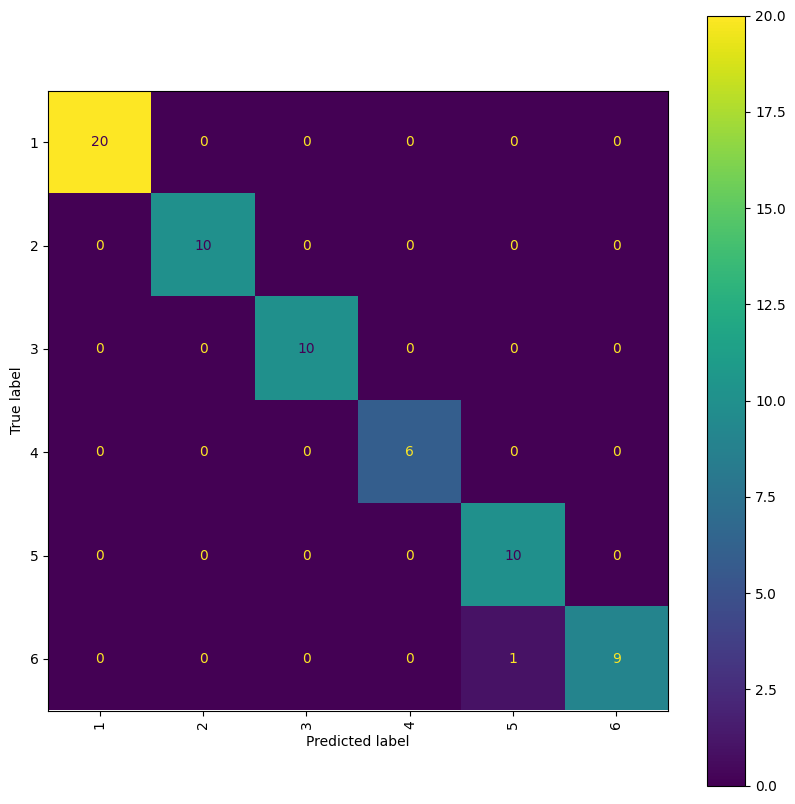

In [23]:
classifier_model = 'text-davinci-003'
classifier_path = file_path_few_shot
print(classifier_model, classifier_path)

df_evaluate_reasons = chained_process_eval(classifier_model, classifier_path)

text-curie-001 prompt_few_shot.jsonl
total number of rounds: 5
current run
0
1
2
3
4
failed number of cases 0


             3
1            5
2           14
3           12
Customer    14
This        18
Name: pred_class, dtype: int64

1    20
2    10
3    10
4     6
5    10
6    10
Name: ground_truth, dtype: int64

              precision    recall  f1-score   support

                   0.00      1.00      0.00         0
           1       1.00      0.25      0.40        20
           2       0.29      0.40      0.33        10
           3       0.58      0.70      0.64        10
           4       1.00      0.00      0.00         6
           5       1.00      0.00      0.00        10
           6       1.00      0.00      0.00        10
    Customer       0.00      1.00      0.00         0
        This       0.00      1.00      0.00         0

    accuracy                           0.24        66
   macro avg       0.54      0.48      0.15        66
weighted avg       0.83      0.24      0.27        66



This        18
2           14
Customer    14
3           12
1            5
             3
Name: pred, dtype: int64

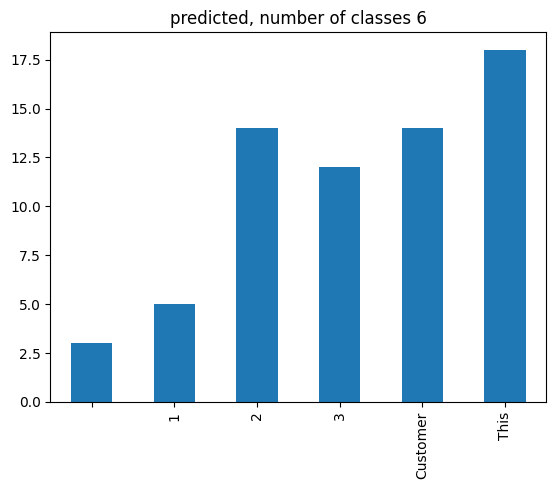

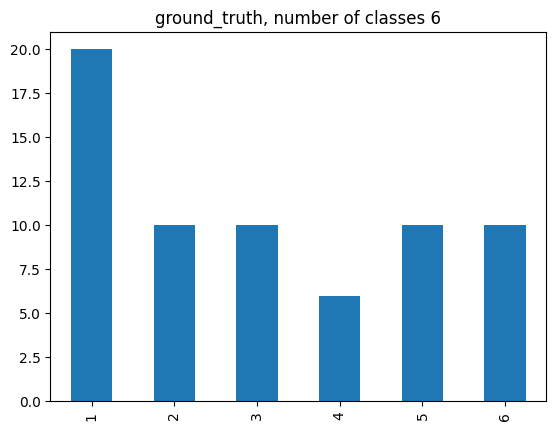

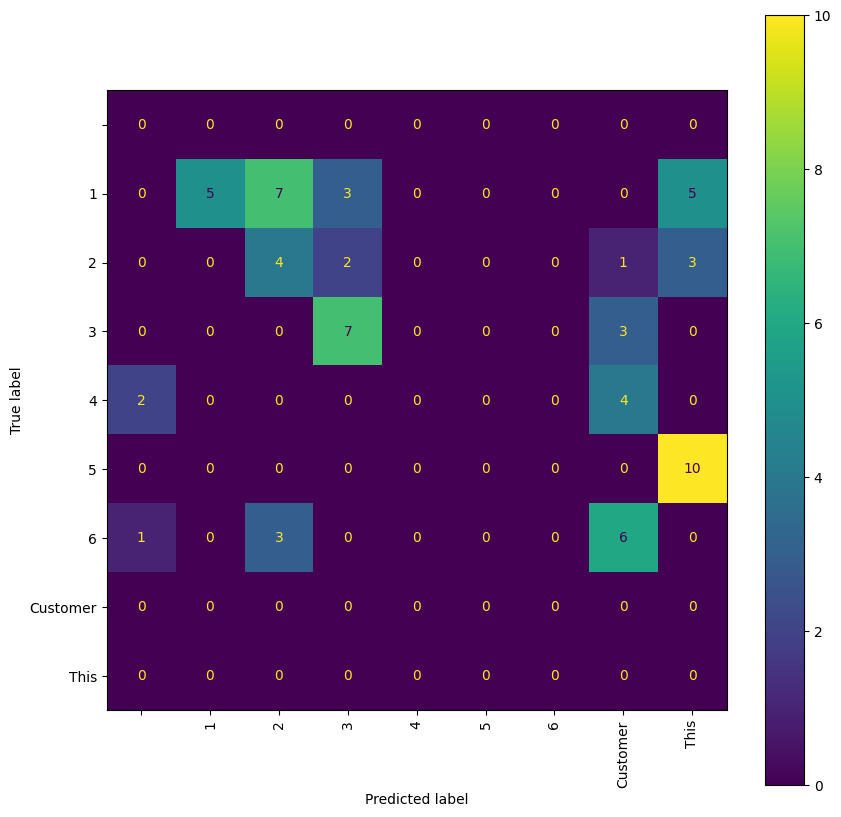

In [24]:
classifier_model = 'text-curie-001'
classifier_path = file_path_few_shot
print(classifier_model, classifier_path)

df_evaluate_reasons = chained_process_eval(classifier_model, classifier_path)